In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from pandas.io import json
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing

# datasetJSONPath = os.getcwd() + "\\datasets\\empire_mimikatz_logonpasswords_2020-08-07103224.json"
datasetJSONPath = os.getcwd() + "/datasets/empire_mimikatz_logonpasswords_2020-08-07103224.json"

df = json.read_json(path_or_buf=datasetJSONPath, lines=True)

2023-04-05 20:09:17.267386: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 20:09:39.396364: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/software/uoa/spack-sw/linux-rhel8-x86_64/gcc-12.1.0/anaconda3-2021.05-g6kymc6js7tc3estviv2s7j4dqo7cant/lib:/opt/slurm/22.05.2-1/lib
2023-04-05 20:09:39.399412: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD

In [24]:
# functions definition

from collections import Counter
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt

# Convert integers to strings
def int_to_str(df):
    for column in df.columns:
        # if dtype is int, convert to string , e.g. EventID
        if isinstance(df[column][0], (int, np.int32, np.int64)):
            df[column] = list(map(str, df[column]))
            
    return df
    
# Count NaN in each column in the dataframe
def count_nan(df):
    for column in df.columns:
        num = df[column].isna().sum()
        print(column, str(num))
    return 0

# make a label list of all 0, except the detected threat are 1
def labelList(num, threatIndices):
    y = [0 for x in range(num)]
    for i in threatIndices:
        y[i] =  1
    return y

# Count the items in data frame
def count_items(df):
    for column in df.columns:
        item = df[column]
        print(column, ": ", sorted(Counter(item).items()))
        
    return 0

# replicate specified data to the end of the dataset
def pd_replicate(X, y, rep_list, times=1):
    for index in rep_list:
        for i in range(times):
            
            X = pd.concat([X, pd.DataFrame(X.iloc[index]).T], axis=0, ignore_index=True)

            y.append(1)
    
    return (X, y)
    
# convert object items in the list into strings
def preprocess_labelEncoder(df):
    
    # replace NAN with 0
    df = df.replace(np.nan, 0, regex=True)
    le = preprocessing.LabelEncoder()
    
    for column in df.columns:            
        df[column] = list(map(str, df[column]))
        le.fit(df[column])
        df[column] = le.transform(df[column])
            
    return df

# convert object items in the list into strings
def preprocess(df):
    
    # replace NAN with 0
    df = df.replace(np.nan, 0, regex=True)
    
    for column in df.columns:            
        df[column] = list(map(str, df[column]))            
    return df

# fit the dataframe and record the label encoders for each column
def labelEncoder_get(df):
    le_dict = {}
    for column in df.columns:
        le = preprocessing.LabelEncoder()
        le.fit(df[column])
        df[column] = le.transform(df[column])
        le_dict[column] = le
    return (df, le_dict)

# input the list of label encoders and transform the dataframe
def labelEncoder_trans(df, le_dict):
    for i, column in enumerate(df.columns):
        le = le_dict[column]
        df[column] = list(map(str, df[column]))
        df[column] = le.transform(df[column])
    return df

# draw confusin matrix and print the classification report
def draw_confusionMatrix(y_test, y_predict):
    confusion_matrix = metrics.confusion_matrix(y_test, y_predict)
    matrix_df = pd.DataFrame(confusion_matrix)
    ax = plt.axes()
    sns.set(font_scale=1.3)
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
    ax.set_title('Confusion Matrix - Decision Tree')
    ax.set_xlabel("Predicted Label", fontsize=15)
    ax.set_ylabel("Actual Label", fontsize=15)
    plt.show()
    print(metrics.classification_report(y_test, y_predict))
    

# Randomly pick data from results and combine them
def random_generator(data_list, pick_nums):
    
    generated_data = pd.DataFrame()
    
    for i, data in enumerate(data_list):
        num = pick_nums[i]
        data_selected = data.sample(num)
        generated_data = pd.concat([generated_data, data_selected], axis=0, ignore_index=True)
    
    return generated_data

# split the training and testing sets manually, make sure that positive data is in the testing set
def train_test_split_m(X, y, positive_list, test_size=0.33):

    sample_len = int(len(X) * 0.33 - len(positive_list))
    
    X_test = X.iloc[positive_list]
    X = X.drop(positive_list)
    
    X_random = X.sample(sample_len)
    X = X.drop(X_random.index)
    X_test = pd.concat([X_test, X_random], axis=0, ignore_index=True)
    y_test = list([1 for i in range(len(positive_list))] + [0 for i in range(sample_len)])

    X_train = X
    y_train = [0 for i in range(len(X_train))]
    
    return (X_train, X_test, y_train, y_test)

In [3]:
# # for debugging only
# count_nan(df)
# count_nan(new_data)

In [3]:
features = ["Channel", "EventID", "ObjectName", "SubjectUserName", "TargetImage", "CallTrace", "ImageLoaded", "@timestamp", "ProcessGuid", "SourceProcessGUID"]
df = df[features]

# change integers to strings to get a better performance in generating new data
df = int_to_str(df)
df.shape

(6026, 10)

## Replicate positive data

There are more negative data than positive data, and results from some analytics (e.g. analytics with merging) are less possible to be generated. So we replicate specific positive data to make CTGAN bias to them.

## Use CTGAN to generate new data

In [4]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df)

In [5]:
# from sdv.tabular import CTGAN
from sdv.single_table import CTGANSynthesizer

# model = CTGAN()#cuda=True
# model.fit(df)
synthesizer = CTGANSynthesizer(
    metadata,
#     enforce_rounding=False,
#     epochs=500,
#     verbose=True,
    cuda=True)

synthesizer.fit(df)

# save and reuse the model
synthesizer.save(filepath=os.getcwd() + '/models/LSASSMemoryReadAccess.pkl')
# model.save(os.getcwd() + '/models/LSASSMemoryReadAccess.pkl')

# model = CTGAN.load(r'models\\LSASSMemoryReadAccess.pkl')

/uoa/home/u15yl21/sharedscratch/.conda/envs/myJupyter_3.7/lib/python3.7/site-packages/rdt/transformers/categorical.py:382: UserWarning: The data contains 1 new categories that were not seen in the original data (examples: {nan}). Creating a vector of all 0s. If you want to model new categories, please fit the transformer again with the new data.
  f'The data contains {len(unseen_categories)} new categories that were not '
/uoa/home/u15yl21/sharedscratch/.conda/envs/myJupyter_3.7/lib/python3.7/site-packages/rdt/transformers/categorical.py:382: UserWarning: The data contains 1 new categories that were not seen in the original data (examples: {nan}). Creating a vector of all 0s. If you want to model new categories, please fit the transformer again with the new data.
  f'The data contains {len(unseen_categories)} new categories that were not '
/uoa/home/u15yl21/sharedscratch/.conda/envs/myJupyter_3.7/lib/python3.7/site-packages/rdt/transformers/categorical.py:382: UserWarning: The data con

In [7]:
new_data = synthesizer.sample(num_rows=1000000)
# new_data = synthesizer.sample(num_rows=1000000)

In [8]:
new_data.head()

,Channel,EventID,ObjectName,SubjectUserName,TargetImage,CallTrace,ImageLoaded,@timestamp,ProcessGuid,SourceProcessGUID
0,Microsoft-Windows-Sysmon/Operational,7,NaN,NaN,NaN,NaN,C:\Windows\assembly\NativeImages_v4.0.30319_64...,2020-08-07T14:33:46.318Z,{297bc33e-660d-5f2d-8407-000000000400},NaN
1,Microsoft-Windows-Sysmon/Operational,10,NaN,NaN,NaN,NaN,C:\Windows\System32\wmidcom.dll,2020-08-07T14:32:47.573Z,NaN,NaN
2,Security,5156,NaN,NaN,NaN,NaN,NaN,2020-08-07T14:33:52.391Z,NaN,NaN
3,Security,12,-,NaN,NaN,NaN,NaN,2020-08-07T14:32:39.438Z,NaN,{297bc33e-5c31-5f2b-2b00-000000000400}
4,Microsoft-Windows-PowerShell/Operational,800,NaN,NaN,NaN,NaN,NaN,2020-08-07T14:33:04.052Z,{9f85ce58-59ed-5f2b-4b00-000000000400},NaN


In [8]:
# # for debugging only
# count_items(preprocess_labelEncoder(df))
# count_items(preprocess_labelEncoder(new_data))

## Use hunter program on new data

In [9]:
# Analytic I
I = (
new_data[features]

[(new_data['Channel'].str.lower() == 'security')
    & ((new_data['EventID'] == '4663') | (new_data['EventID'] == '4656'))
    & (new_data['ObjectName'].str.contains('.*lsass.exe', regex=True))
    & (~new_data['SubjectUserName'].str.endswith('.*$', na=False))
]
)
I

,Channel,EventID,ObjectName,SubjectUserName,TargetImage,CallTrace,ImageLoaded,@timestamp,ProcessGuid,SourceProcessGUID
6088,Security,4663,\Device\HarddiskVolume2\Windows\System32\lsass...,pgustavo,NaN,NaN,NaN,2020-08-07T14:33:23.150Z,NaN,NaN
7908,Security,4663,\Device\HarddiskVolume2\Windows\System32\lsass...,pgustavo,NaN,NaN,NaN,2020-08-07T14:34:01.678Z,NaN,NaN
19864,Security,4656,\Device\HarddiskVolume2\Windows\System32\lsass...,pgustavo,NaN,NaN,NaN,2020-08-07T14:33:45.282Z,NaN,NaN
27133,Security,4656,\Device\HarddiskVolume2\Windows\System32\lsass...,pgustavo,NaN,NaN,NaN,2020-08-07T14:32:47.568Z,NaN,NaN
30217,Security,4656,\Device\HarddiskVolume2\Windows\System32\lsass...,-,NaN,NaN,NaN,2020-08-07T14:33:23.165Z,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
979646,Security,4663,\Device\HarddiskVolume2\Windows\System32\lsass...,pgustavo,NaN,NaN,NaN,2020-08-07T14:32:45.478Z,NaN,NaN
983663,Security,4656,\Device\HarddiskVolume2\Windows\System32\lsass...,pgustavo,NaN,NaN,NaN,2020-08-07T14:34:38.825Z,NaN,NaN
986116,Security,4656,\Device\HarddiskVolume2\Windows\System32\lsass...,WORKSTATION5$,NaN,NaN,NaN,2020-08-07T14:32:39.438Z,NaN,NaN
994126,Security,4656,\Device\HarddiskVolume2\Windows\System32\lsass...,pgustavo,NaN,NaN,NaN,2020-08-07T14:34:14.697Z,NaN,NaN


In [10]:
# Analytic II
II = (
new_data[features]

[(new_data['Channel'] == 'Microsoft-Windows-Sysmon/Operational')
    & (new_data['EventID'] == '10')
    & (new_data['TargetImage'].str.contains('.*lsass.exe', regex=True))
    & (new_data['CallTrace'].str.contains('.*UNKNOWN*', regex=True))
]
)
II

,Channel,EventID,ObjectName,SubjectUserName,TargetImage,CallTrace,ImageLoaded,@timestamp,ProcessGuid,SourceProcessGUID
693,Microsoft-Windows-Sysmon/Operational,10,NaN,NaN,C:\windows\system32\lsass.exe,C:\windows\SYSTEM32\ntdll.dll+9c534|C:\windows...,NaN,2020-08-07T14:32:48.986Z,NaN,{297bc33e-5c2f-5f2b-1000-000000000400}
3210,Microsoft-Windows-Sysmon/Operational,10,NaN,NaN,C:\windows\system32\lsass.exe,C:\windows\SYSTEM32\ntdll.dll+9d8e4|C:\windows...,NaN,2020-08-07T14:32:47.566Z,NaN,{297bc33e-5c2f-5f2b-1000-000000000400}
3400,Microsoft-Windows-Sysmon/Operational,10,NaN,NaN,C:\windows\system32\lsass.exe,C:\windows\SYSTEM32\ntdll.dll+9c534|C:\windows...,NaN,2020-08-07T14:33:45.311Z,NaN,{297bc33e-5c2f-5f2b-1000-000000000400}
3985,Microsoft-Windows-Sysmon/Operational,10,NaN,NaN,C:\windows\system32\lsass.exe,C:\windows\SYSTEM32\ntdll.dll+9d8e4|C:\windows...,NaN,2020-08-07T14:33:46.312Z,NaN,{297bc33e-5c2f-5f2b-1000-000000000400}
14203,Microsoft-Windows-Sysmon/Operational,10,NaN,NaN,C:\windows\system32\lsass.exe,C:\windows\SYSTEM32\ntdll.dll+9c534|C:\windows...,NaN,2020-08-07T14:32:56.278Z,NaN,{297bc33e-5c2f-5f2b-1000-000000000400}
...,...,...,...,...,...,...,...,...,...,...
982630,Microsoft-Windows-Sysmon/Operational,10,NaN,NaN,C:\windows\system32\lsass.exe,C:\windows\SYSTEM32\ntdll.dll+9c534|C:\windows...,NaN,2020-08-07T14:34:38.832Z,NaN,{297bc33e-5c2f-5f2b-1000-000000000400}
989394,Microsoft-Windows-Sysmon/Operational,10,NaN,NaN,C:\windows\system32\lsass.exe,C:\windows\SYSTEM32\ntdll.dll+9d8e4|C:\windows...,NaN,2020-08-07T14:32:47.826Z,NaN,{297bc33e-5c2f-5f2b-1000-000000000400}
989601,Microsoft-Windows-Sysmon/Operational,10,NaN,NaN,C:\windows\system32\lsass.exe,C:\windows\SYSTEM32\ntdll.dll+9c534|C:\windows...,NaN,2020-08-07T14:33:45.308Z,NaN,{297bc33e-5c2f-5f2b-1000-000000000400}
989818,Microsoft-Windows-Sysmon/Operational,10,NaN,NaN,C:\windows\system32\lsass.exe,C:\windows\SYSTEM32\ntdll.dll+9d8e4|C:\windows...,NaN,2020-08-07T14:33:28.179Z,NaN,{297bc33e-5c2f-5f2b-1000-000000000400}


In [11]:
# Analytic III
III = (
new_data[features]
    
[(new_data['Channel'] == 'Microsoft-Windows-Sysmon/Operational')
    & (new_data['EventID'] == '7')
    & (
        (new_data['ImageLoaded'].str.contains('.*samlib.dll', regex=True))
        | (new_data['ImageLoaded'].str.contains('.*vaultcli.dll', regex=True))
        | (new_data['ImageLoaded'].str.contains('.*hid.dll', regex=True))
        | (new_data['ImageLoaded'].str.contains('.*winscard.dll', regex=True))
        | (new_data['ImageLoaded'].str.contains('.*cryptdll.dll', regex=True))
    )
    & (new_data['@timestamp'].between('2020-06-00 00:00:00.000','2020-08-20 00:00:00.000'))
]
# .groupby(['ProcessGuid','Image'])['ImageLoaded'].count().sort_values(ascending=False)
# ).to_frame()
)
III

,Channel,EventID,ObjectName,SubjectUserName,TargetImage,CallTrace,ImageLoaded,@timestamp,ProcessGuid,SourceProcessGUID
222,Microsoft-Windows-Sysmon/Operational,7,NaN,NaN,NaN,NaN,C:\Windows\System32\vaultcli.dll,2020-08-07T14:32:49.220Z,{297bc33e-65d0-5f2d-8207-000000000400},NaN
6694,Microsoft-Windows-Sysmon/Operational,7,NaN,NaN,NaN,NaN,C:\Windows\System32\cryptdll.dll,2020-08-07T14:32:57.588Z,{297bc33e-65d0-5f2d-8207-000000000400},NaN
9062,Microsoft-Windows-Sysmon/Operational,7,NaN,NaN,NaN,NaN,C:\Windows\System32\samlib.dll,2020-08-07T14:33:46.318Z,{297bc33e-660d-5f2d-8407-000000000400},NaN
10609,Microsoft-Windows-Sysmon/Operational,7,NaN,NaN,NaN,NaN,C:\Windows\System32\cryptdll.dll,2020-08-07T14:32:47.585Z,{297bc33e-65d0-5f2d-8207-000000000400},NaN
35313,Microsoft-Windows-Sysmon/Operational,7,NaN,NaN,NaN,NaN,C:\Windows\System32\vaultcli.dll,2020-08-07T14:34:28.748Z,{297bc33e-65d0-5f2d-8207-000000000400},NaN
...,...,...,...,...,...,...,...,...,...,...
979175,Microsoft-Windows-Sysmon/Operational,7,NaN,NaN,NaN,NaN,C:\Windows\System32\cryptdll.dll,2020-08-07T14:33:04.052Z,{297bc33e-65d0-5f2d-8207-000000000400},NaN
983620,Microsoft-Windows-Sysmon/Operational,7,NaN,NaN,NaN,NaN,C:\Windows\System32\cryptdll.dll,2020-08-07T14:33:04.052Z,{297bc33e-65d0-5f2d-8207-000000000400},NaN
987774,Microsoft-Windows-Sysmon/Operational,7,NaN,NaN,NaN,NaN,C:\Windows\System32\vaultcli.dll,2020-08-07T14:32:45.480Z,{297bc33e-65d0-5f2d-8207-000000000400},NaN
991067,Microsoft-Windows-Sysmon/Operational,7,NaN,NaN,NaN,NaN,C:\Windows\System32\vaultcli.dll,2020-08-07T14:34:28.750Z,{297bc33e-65d0-5f2d-8207-000000000400},NaN


In [13]:
# Analytic IV
imageLoadDf = (
new_data[features]

[(new_data['Channel'] == 'Microsoft-Windows-Sysmon/Operational')
    & (new_data['EventID'] == '7')
    & (
        (new_data['ImageLoaded'].str.contains('.*samlib.dll', regex=True))
        | (new_data['ImageLoaded'].str.contains('.*vaultcli.dll', regex=True))
        | (new_data['ImageLoaded'].str.contains('.*hid.dll', regex=True))
        | (new_data['ImageLoaded'].str.contains('.*winscard.dll', regex=True))
        | (new_data['ImageLoaded'].str.contains('.*cryptdll.dll', regex=True))
    )
    & (new_data['@timestamp'].between('2020-06-00 00:00:00.000','2020-08-20 00:00:00.000'))
]
# .groupby(['ProcessGuid','Image'])['ImageLoaded'].count().sort_values(ascending=False)
# ).to_frame()
)


processAccessDf = (
new_data[features]

[(new_data['Channel'] == 'Microsoft-Windows-Sysmon/Operational')
    & (new_data['EventID'] == '10')
    & (new_data['TargetImage'].str.contains('.*lsass.exe', regex=True))
    & (new_data['CallTrace'].str.contains('.*UNKNOWN*', regex=True))
]
)

# (
# pd.merge(imageLoadDf, processAccessDf,
#     left_on = 'ProcessGuid', right_on = 'SourceProcessGUID', how = 'inner')
# )

IV = (
imageLoadDf[features]
    
[(imageLoadDf['ProcessGuid'].isin(processAccessDf['SourceProcessGUID']))
    & (imageLoadDf['ProcessGuid'])]
)
    
# V = (
# processAccessDf[features]
    
# [processAccessDf['SourceProcessGUID'].isin(imageLoadDf['ProcessGuid'])]
# )

IV

,Channel,EventID,ObjectName,SubjectUserName,TargetImage,CallTrace,ImageLoaded,@timestamp,ProcessGuid,SourceProcessGUID
222,Microsoft-Windows-Sysmon/Operational,7,NaN,NaN,NaN,NaN,C:\Windows\System32\vaultcli.dll,2020-08-07T14:32:49.220Z,{297bc33e-65d0-5f2d-8207-000000000400},NaN
6694,Microsoft-Windows-Sysmon/Operational,7,NaN,NaN,NaN,NaN,C:\Windows\System32\cryptdll.dll,2020-08-07T14:32:57.588Z,{297bc33e-65d0-5f2d-8207-000000000400},NaN
10609,Microsoft-Windows-Sysmon/Operational,7,NaN,NaN,NaN,NaN,C:\Windows\System32\cryptdll.dll,2020-08-07T14:32:47.585Z,{297bc33e-65d0-5f2d-8207-000000000400},NaN
35313,Microsoft-Windows-Sysmon/Operational,7,NaN,NaN,NaN,NaN,C:\Windows\System32\vaultcli.dll,2020-08-07T14:34:28.748Z,{297bc33e-65d0-5f2d-8207-000000000400},NaN
46161,Microsoft-Windows-Sysmon/Operational,7,NaN,NaN,NaN,NaN,C:\Windows\System32\cryptdll.dll,2020-08-07T14:33:03.900Z,{297bc33e-65d0-5f2d-8207-000000000400},NaN
...,...,...,...,...,...,...,...,...,...,...
979175,Microsoft-Windows-Sysmon/Operational,7,NaN,NaN,NaN,NaN,C:\Windows\System32\cryptdll.dll,2020-08-07T14:33:04.052Z,{297bc33e-65d0-5f2d-8207-000000000400},NaN
983620,Microsoft-Windows-Sysmon/Operational,7,NaN,NaN,NaN,NaN,C:\Windows\System32\cryptdll.dll,2020-08-07T14:33:04.052Z,{297bc33e-65d0-5f2d-8207-000000000400},NaN
987774,Microsoft-Windows-Sysmon/Operational,7,NaN,NaN,NaN,NaN,C:\Windows\System32\vaultcli.dll,2020-08-07T14:32:45.480Z,{297bc33e-65d0-5f2d-8207-000000000400},NaN
991067,Microsoft-Windows-Sysmon/Operational,7,NaN,NaN,NaN,NaN,C:\Windows\System32\vaultcli.dll,2020-08-07T14:34:28.750Z,{297bc33e-65d0-5f2d-8207-000000000400},NaN


### Generate data
Randomly pick data from each analytic's results, and combine them as the generated dataset.

In [21]:
# randomly pick from results of analytics
results = [I, II, III, IV]
# pick_nums = [112, 362, 236, 200]
pick_nums = [100, 100, 100, 100]
gen_data = random_generator(results, pick_nums)

# gen_data = new_data.iloc[[43318, 202587, 344456, 432371, 610375]]
gen_data.shape

(400, 10)

## Decision Tree

### Preprocess data

In [28]:
# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# df = scaler.fit_transform(df)

### Original data

Balanced accuracy score: 0.75


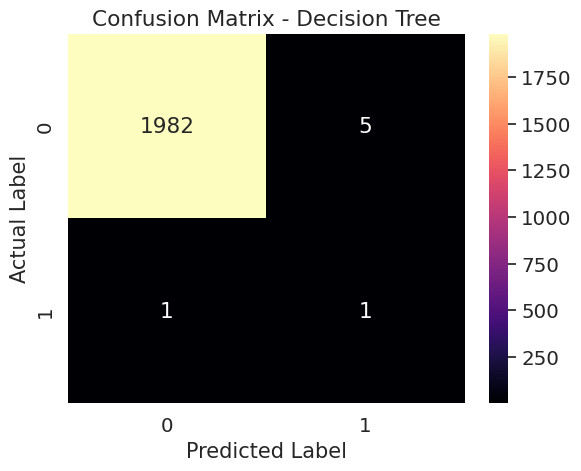

<Figure size 1000x700 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1987
           1       0.17      0.50      0.25         2

    accuracy                           1.00      1989
   macro avg       0.58      0.75      0.62      1989
weighted avg       1.00      1.00      1.00      1989



In [22]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

X = preprocess_labelEncoder(df)
y = labelList(df.shape[0], [2459, 2460, 2450, 2430, 2437, 2438, 2448])
clf = DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)

clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print("Balanced accuracy score: {:.2f}".format(metrics.balanced_accuracy_score(y_test, y_predict)))
draw_confusionMatrix(y_test, y_predict)

### Original data with generated data
Generated data should only be added into trianing set.

Balanced accuracy score: 0.49


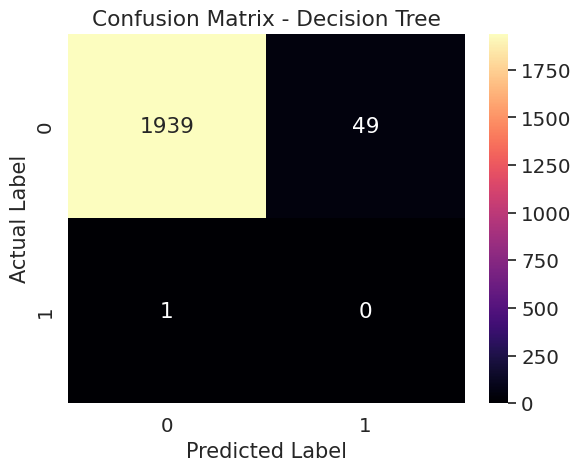

<Figure size 1000x700 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1988
           1       0.00      0.00      0.00         1

    accuracy                           0.97      1989
   macro avg       0.50      0.49      0.49      1989
weighted avg       1.00      0.97      0.99      1989



In [23]:
y = labelList(df.shape[0], [58, 57, 61, 211])
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.33, random_state=42)

# add generated data to the original training set
X_train_new = pd.concat([X_train, gen_data], axis=0)

X_train_new = preprocess_labelEncoder(X_train_new)

# generated data are all positive
for i in range(len(gen_data)):
    y_train.append(1)

clf = DecisionTreeClassifier()

clf.fit(X_train_new, y_train)
y_predict = clf.predict(preprocess_labelEncoder(X_test))
print("Balanced accuracy score: {:.2f}".format(metrics.balanced_accuracy_score(y_test, y_predict)))
draw_confusionMatrix(y_test, y_predict)

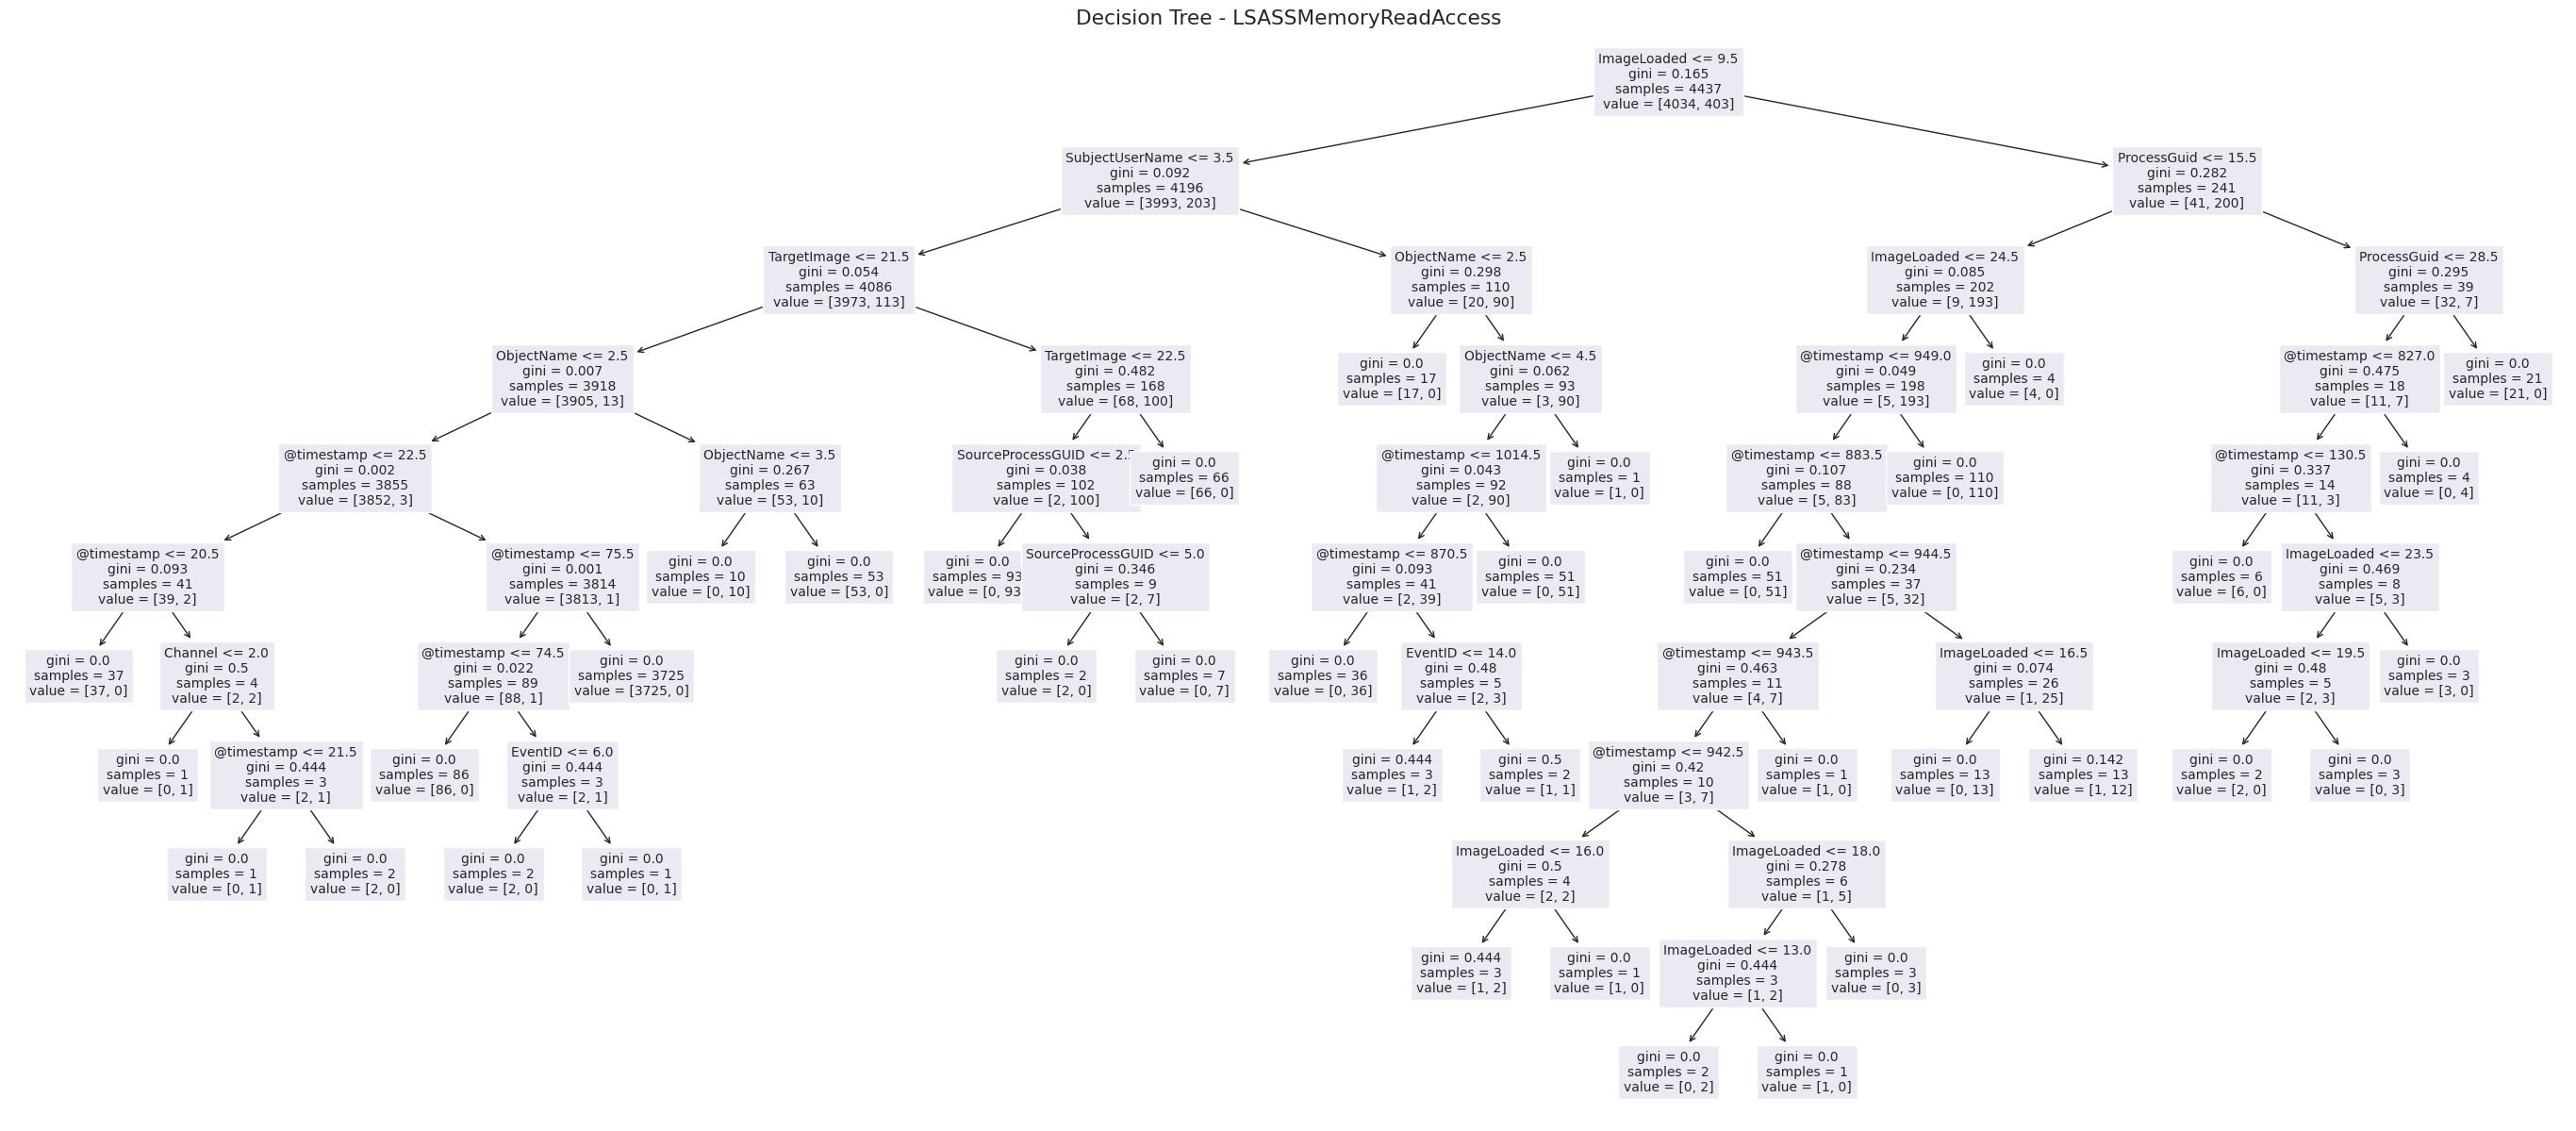

In [27]:
# draw the tree
from sklearn import tree

plt.figure(figsize=(35, 15))
tree.plot_tree(clf, feature_names=features, fontsize=10)
plt.title("Decision Tree - LSASSMemoryReadAccess")
plt.savefig(r'DecisionTree/LSASSMemoryReadAccess.png', dpi=100, transparent=True)

## Save generated data

In [28]:
# # extract to JSON file
# dataset.reset_index(drop=True, inplace=True)
gen_data.to_json(os.getcwd() + '/generated_datasets/covenant_copy_smb_CreateRequest_new.json', orient='records')

# dataset = json.read_json(path_or_buf=os.getcwd()+ "\\generated_datasets"+ "\\covenant_copy_smb_CreateRequest_new.json")
# dataset.head()